# Inference

This notebook enables to predict the closest images of a sketch. 

In [134]:
# Imports
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams['axes.titlesize'] = 15

In [135]:
from src.data.loader_factory import load_data
from src.data.utils import default_image_loader
from src.models.encoder import EncoderCNN
from src.models.utils import load_checkpoint, get_model
from src.models.test import get_test_data
from src.models.metrics import get_similarity

In [136]:
class Args:
    dataset = "sketchy_extend"
    data_path = "../io/data/raw"
    emb_size = 256
    grl_lambda = 0.5
    nopretrain = False
    epochs = 1000
    batch_size = 10
    seed = 42
    load = None
    early_stop = 20
    ngpu = 1
    prefetch = 2
    log = "../io/models/"
    log_interval = 20
    attn = True
    plot = False
    cuda = False

args = Args()

In [137]:
NUM_CLOSEST = 4

In [138]:
BEST_CHECKPOINT = '../io/models/1_run-batch_size_10/checkpoint.pth'
EMBEDDING_PATH = '../io/data/processed/embeddings.ending'

## Inference

In [139]:
class Inference():
    
    def __init__(self, model_path, embedding_path, dataset_type):
        
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.loader = default_image_loader

        self.im_net, self.sk_net = get_model(args, model_path)
        self.im_net.eval()
        self.sk_net.eval()
        torch.set_grad_enabled(False)
        
        dict_path = embedding_path.replace('.ending', '_dict_class.json')
        with open(dict_path, 'r') as fp:
            self.dict_class = json.load(fp)
        
        meta_path = embedding_path.replace('.ending', dataset_type + '_meta.csv')
        df = pd.read_csv(meta_path, sep=' ')
        self.images_fnames = df['fnames'].values
        self.images_classes = df['classes'].values
        
        array_path = embedding_path.replace('.ending', dataset_type + '_array.npy')
        with open(array_path, 'rb') as f:
            self.images_embeddings = np.load(f)
        
    def inference_sketch(self, sketch_fname, plot=True):
        ''' For now just process a sketch but TODO decide how to proceed later'''
        
        sketch = self.transform(self.loader(sketch_fname)).unsqueeze(0) # unsqueeze because 1 sketch (no batch)
        sketch_embedding, _ = self.sk_net(sketch)
        self.get_closest_images(sketch_embedding)
        
        if plot:
            self.plot_closest(sketch_fname)
        
    def get_closest_images(self, sketch_embedding):
        '''
        Based on a sketch embedding, retrieve the index of the closest images
        '''
        similarity = get_similarity(sketch_embedding.detach().numpy(), self.images_embeddings)
        arg_sorted_sim = (-similarity).argsort()
        
        self.sorted_fnames = [self.images_fnames[i]
                              for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]]
        self.sorted_labels = [self.images_classes[i]
                              for i in arg_sorted_sim[0][0:NUM_CLOSEST + 1]]
        
    def plot_closest(self, sketch_fname):
        fig, axes = plt.subplots(1, NUM_CLOSEST + 1)

        sk = mpimg.imread(sketch_fname)
        axes[0].imshow(sk)
        axes[0].set(title='Sketch \n Label: ' + sketch_fname.split('/')[-2])

        for i in range(1, NUM_CLOSEST + 1):
            im = mpimg.imread('../' + self.sorted_fnames[i-1])
            axes[i].imshow(im)
            axes[i].set(title='Closest image ' + str(i) + 
                        '\n Label: ' + self.dict_class[str(self.sorted_labels[i-1])])

        plt.subplots_adjust(wspace=0.25, hspace=-0.35)

In [140]:
inference_test = Inference(BEST_CHECKPOINT, EMBEDDING_PATH, '_test')

# Results

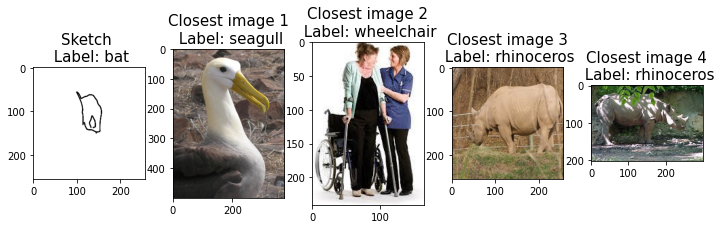

In [141]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/bat/n02139199_1332-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

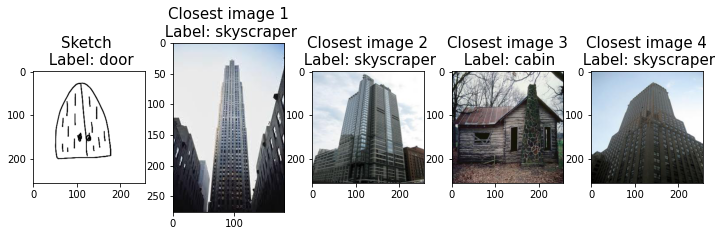

In [142]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/door/n03222176_681-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

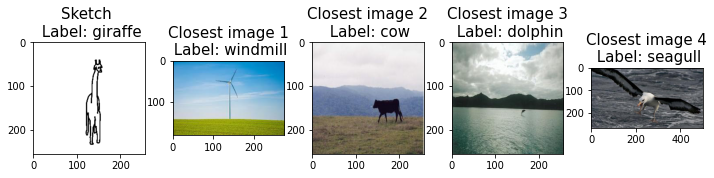

In [143]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/giraffe/n02439033_67-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

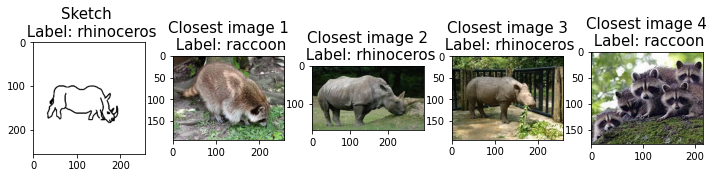

In [144]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/rhinoceros/n02391994_135-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

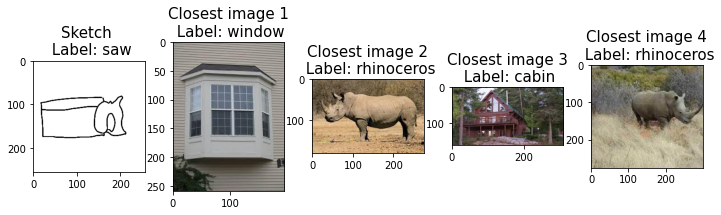

In [145]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/saw/n02770585_1371-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

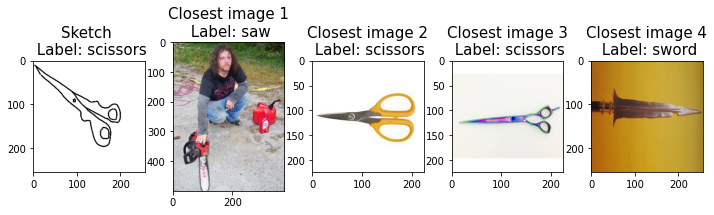

In [146]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/scissors/n03044934_5634-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

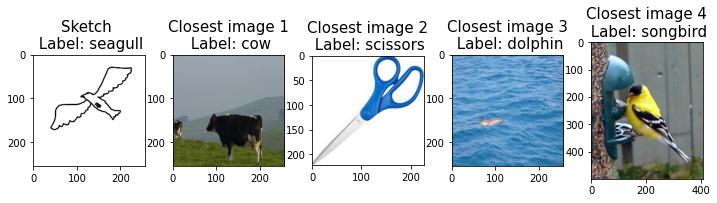

In [147]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/seagull/n02041246_30-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

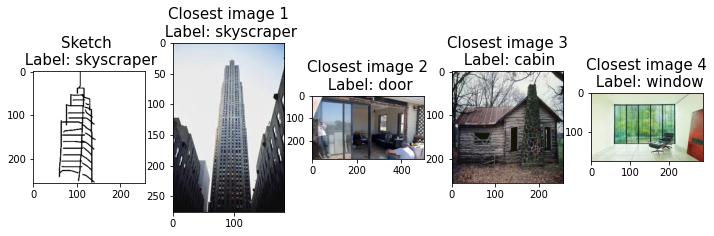

In [148]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/skyscraper/n04233124_498-1.png'
inference_test.inference_sketch(sketch_fname, plot=True)

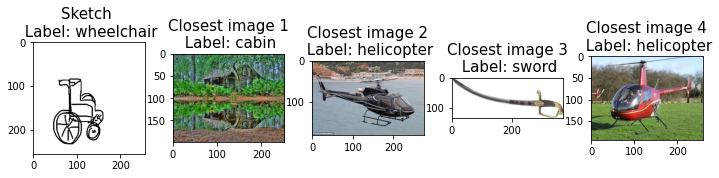

In [149]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/wheelchair/n04576002_150-2.png'
inference_test.inference_sketch(sketch_fname, plot=True)